# Exclusion



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xml.etree.ElementTree
import os,glob,sys
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
sys.path.append('C:\\Users\\Vinny\\work\\vimms')
sys.path.append('C:\\Users\\Vinny\\work\\pymzmine')

sys.path.append('/Users/simon/git/vimms')
sys.path.append('/Users/simon/git/pymzm')

sys.path.append('/home/simon/git/vimms')
sys.path.append('/home/simon/git/pymzm')


In [4]:
from vimms.PythonMzmine import *
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController,ExcludingTopNController
from vimms.PythonMzmine import *

In [5]:
from vimms.Roi import make_roi, RoiToChemicalCreator
from vimms.BOMAS import *
from vimms.Common import *
from vimms.Environment import *
from pathlib import Path
from vimms.PlotsForPaper import get_frag_events

In [6]:
from vimms.DataGenerator import extract_hmdb_metabolite, get_data_source, get_spectral_feature_database

In [7]:
set_log_level_warning()

# Test on Simulator (with same settings as MS)

In [8]:
base_dir = os.path.abspath('/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Trained Models')
base_dir = os.path.abspath('/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/TopN_vs_ROI/QCB/simulator_input')
ps_frag_QCB = load_obj(Path(base_dir, 'peak_sampler_mz_rt_int_beerqcb_fragmentation.p'))

In [9]:
QCB_MZML2CHEMS_DICT = {'min_ms1_intensity': 0,
                  'mz_tol': 5,
                  'mz_units':'ppm',
                  'min_length':1,
                  'min_intensity':0,
                  'start_rt':0,
                  'stop_rt':1560}

In [10]:
seed_mzml_file = '/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Experimental_Results/20200715_TopN_vs_ROI/from_controllers/QCB/TopN_QCB.mzML'
# TopN_QCB_dataset = mzml2chems(seed_mzml_file, ps_frag_QCB, QCB_MZML2CHEMS_DICT, n_peaks=None)

In [11]:
# save_obj(TopN_QCB_dataset, '/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Experimental_Results/20200715_TopN_vs_ROI/from_controllers/QCB/TopN_QCB.p')

In [ ]:
# TopN_QCB_dataset = load_obj('/Users/simon/OneDrive - University of Glasgow/CLDS Metabolomics Project/TopNvsTopNroi/QCB/SimulatorTests/TopN_QCB_dataset.mzml')
# TopN_QCB_dataset = load_obj(Path(base_dir,'TopN_QCB_dataset.mzml'))
TopN_QCB_dataset = load_obj(Path(base_dir,'/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Experimental_Results/20200715_TopN_vs_ROI/from_controllers/QCB/Fullscan_QCB.p'))

## Set some parameters that are constant for all simulations

In [12]:

min_rt = 0
max_rt = 26*60 # entire run
min_ms1_intensity = 5000
mz_tol = 10
rt_tol = 15
N = 10


# these are derived from real data (see bottom of notebook)
# roi_time_dict = {1: 0.71,2:0.20}
topn_time_dict = {1: 0.60,2:0.20}


ionisation_mode = POSITIVE
isolation_width = 1

test_path = '/Users/simon/git/vimms/experimental/simon_res/'
# min_roi_intensity = 500
# min_roi_length = 3 # still in scans, as to work in seconds, need to pass parameter. But doesn't matter when parameter below is equal to 1!
# min_roi_length_for_fragmentation = 1



In [13]:
from vimms.MassSpec import IndependentMassSpectrometer

### Top N

In [14]:
controller = TopNController(ionisation_mode, N, isolation_width, mz_tol, rt_tol, min_ms1_intensity)

mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCB_dataset,
                                        ps_frag_QCB, add_noise=True,
                                       scan_duration_dict = topn_time_dict)

env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

# test_path = '/Users/simon/git/vimms/experimental/simon_res/'
env.write_mzML(test_path, 'topN.mzml')

(1560.000s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.400000000148/1560 [01:45<00:00, 14.82it/s] 


## Excluded

In [60]:
t0_vals = [1,3,5,10,15,30,60]
t0_vals = [1,3,10,15,30,60]
rt_tol_vals = [15,30,60,120,240,300,360]
rt_tol_vals = [15,60,120,240,360,3600]

In [61]:
for t0 in t0_vals:
    for r in rt_tol_vals:
        if t0 > r:
            # impossible combination
            continue
        print(t0,r)
        out_name = 'exlude_log_{}_{}.mzml'.format(t0,r)

        if os.path.isfile(os.path.join(test_path,out_name)):
            print("Already done")
            continue
        
        # ROI can also be fragmented again if intensity falls to <1% of the max *since* last fragmentation
        from vimms.Controller import TopN_SmartRoiController
        controller = ExcludingTopNController(ionisation_mode, N, isolation_width, mz_tol, 
                                            r,min_ms1_intensity, exclusion_t_0 = t0, log_intensity = True)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCB_dataset,
                                                ps_frag_QCB,
                                                add_noise=True,
                                               scan_duration_dict=topn_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        env.write_mzML(test_path, out_name)

1 15
Already done
1 60
Already done
1 120


(1560.000s) ms_level=2 N=10 DEW=120: 100%|█████████▉| 1559.800000000155/1560 [01:40<00:00, 15.57it/s] 


1 240
Already done
1 360
Already done
1 3600
Already done
3 15
Already done
3 60
Already done
3 120


(1560.000s) ms_level=2 N=10 DEW=120: 100%|█████████▉| 1559.800000000155/1560 [01:39<00:00, 15.71it/s] 


3 240
Already done
3 360
Already done
3 3600
Already done
10 15
Already done
10 60
Already done
10 120


(1560.000s) ms_level=2 N=10 DEW=120: 100%|█████████▉| 1559.8000000001543/1560 [01:38<00:00, 15.84it/s]


10 240
Already done
10 360
Already done
10 3600
Already done
15 15


(1560.000s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.400000000148/1560 [01:28<00:00, 17.66it/s] 


15 60


(1560.200s) ms_level=1 N=10 DEW=60: 100%|█████████▉| 1559.6000000001486/1560 [01:33<00:00, 16.64it/s]


15 120


(1560.400s) ms_level=1 N=10 DEW=120: 100%|█████████▉| 1559.8000000001482/1560 [01:39<00:00, 15.61it/s]


15 240


(1560.400s) ms_level=1 N=10 DEW=240: 100%|█████████▉| 1559.8000000001484/1560 [01:48<00:00, 14.37it/s]


15 360


(1560.000s) ms_level=1 N=10 DEW=360: 100%|█████████▉| 1559.400000000148/1560 [01:57<00:00, 13.26it/s] 


15 3600


(1560.400s) ms_level=1 N=10 DEW=3600: 100%|█████████▉| 1559.8000000001482/1560 [02:18<00:00, 11.27it/s]


30 60
Already done
30 120


(1560.400s) ms_level=1 N=10 DEW=120: 100%|█████████▉| 1559.8000000000939/1560 [01:38<00:00, 15.86it/s]


30 240
Already done
30 360
Already done
30 3600
Already done
60 60
Already done
60 120


(1560.200s) ms_level=1 N=10 DEW=120: 100%|█████████▉| 1559.6000000000445/1560 [01:35<00:00, 16.33it/s]


60 240
Already done
60 360
Already done
60 3600
Already done


## ROI-based scoring

- Make the ROIs in the data
- Count how many have fragmentations in them

In [ ]:
from vimms.Roi import make_roi

In [ ]:
topn_file = os.path.join(test_path, 'topN.mzml')
roi_file = os.path.join(test_path,'ROI.mzml')
smart_file = os.path.join(test_path,'SMART.mzml')

In [ ]:
good_topn,junk_topn = make_roi(topn_file,mz_tol = mz_tol,mz_units = 'ppm',min_length = min_roi_length,min_intensity = min_roi_intensity)

In [ ]:
good_roi,junk_roi = make_roi(roi_file,mz_tol = mz_tol,mz_units = 'ppm',min_length = min_roi_length,min_intensity = min_roi_intensity)

In [ ]:
good_smart,junk_smart = make_roi(smart_file,mz_tol = mz_tol,mz_units = 'ppm',min_length = min_roi_length,min_intensity = min_roi_intensity)

In [ ]:
sys.path.append('/Users/simon/git/pymzm')
from ms2_matching import MZMLFile
topn_mz_file = MZMLFile(topn_file)
roi_mz_file = MZMLFile(roi_file)
smart_mz_file = MZMLFile(smart_file)

In [ ]:

def summarise(mz_file_object):
    n_scans = len(mz_file_object.scans)
    n_ms1_scans = len(list(filter(lambda x: x.ms_level == 1,mz_file_object.scans)))
    n_ms2_scans = len(list(filter(lambda x: x.ms_level == 2,mz_file_object.scans)))
    print("Total scans = {}, MS1 = {}, MS2 = {}".format(n_scans,n_ms1_scans,n_ms2_scans))
print("TopN:")
summarise(topn_mz_file)
print("ROI:")
summarise(roi_mz_file)
print("SMART:")
summarise(smart_mz_file)



In [ ]:
# This method is very slow.... :-)

def match_scans_to_rois(mz_file_object,roi_list):
    roi2scan = {roi:[] for roi in roi_list}
    scan2roi = {scan:[] for scan in filter(lambda x: x.ms_level == 2,mz_file_object.scans)}
    for scan in mz_file_object.scans:
        if scan.ms_level == 2:
            pmz = scan.precursor_mz
            scan_rt_in_seconds = 60*scan.previous_ms1.rt_in_minutes
            in_mz_range = list(filter(lambda x: min(x.mz_list) <= pmz and max(x.mz_list) >= pmz,roi_list))
            in_rt_range = list(filter(lambda x: x.rt_list[0]<= scan_rt_in_seconds and x.rt_list[-1] >= scan_rt_in_seconds,in_mz_range))
            for roi in in_rt_range:
                roi2scan[roi].append(scan)
                scan2roi[scan].append(roi)
    return roi2scan,scan2roi



In [ ]:
roi_roi2scan,roi_scan2roi = match_scans_to_rois(roi_mz_file,good_roi)

In [ ]:
topn_roi2scan,topn_scan2roi = match_scans_to_rois(topn_mz_file,good_topn)

In [ ]:
smart_roi2scan,smart_scan2roi = match_scans_to_rois(smart_mz_file,good_smart)

In [ ]:
# compute proportion of ROIs that have scans for each
def prop_roi_with_scans(roi2scan):
    with_scan = 0
    without_scan = 0
    for r,scans in roi2scan.items():
        if len(scans) == 0:
            without_scan += 1
        else:
            with_scan += 1
    return with_scan,without_scan,len(roi2scan)

In [ ]:
print("ROI: ",prop_roi_with_scans(roi_roi2scan))
print("topN: ",prop_roi_with_scans(topn_roi2scan))
print("SMART: ",prop_roi_with_scans(smart_roi2scan))

# Test with the picked peaks

- This code uses a method called `load_picked_boxes` and one called `map_boxes_to_scans` from my pymzm repository (in `ms2_matching.py`)
- Load picked boxes loads the peak *boxes* from the output of mzmine (i.e. min/max mz, min/max rt)
- Map boxes to scans takes an MZMLFile object (also from the pymzm repo) and maps the ms2 scans to the boxes (and vice versa). Note that this method was originally designed to map scans to any box they overlap with (i.e. any box where the precursor plus or minus isolation intersected the box). This can be *switched off* by setting the isolation with to zero. Now, it will only find things where the precursor mz is in the box (and RT is ok, obviously)
- We can then simply see how many of the boxes are associated with scans and this tells us how many picked peaks have scans

/Users/simon/git/vimms/experimental/simon_res/


In [18]:
# test with picked peaks
# from ms2_matching import MZMLFile

# Big differences between the following two files!
# perhaps an alignment thing...
# peak_csv_file = os.path.join(qcb_dir,'from_controller_TopN_QCB_pp.csv')
# peak_csv_file = os.path.join(qcb_dir,'QCB_22May19_1_pp.csv') 
peak_csv_file = os.path.join(test_path,'QCB','qcb_pp_wide.csv')
peak_csv_file = '/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Experimental_Results/20200715_TopN_vs_ROI/from_controllers/QCB/TopN_QCB_box.csv'

from ms2_matching import load_picked_boxes,map_boxes_to_scans
boxes = load_picked_boxes(peak_csv_file)

In [37]:
# dp_values = [0.1,0.5,1,5,20,50]
# dp_values = [0.1,0.5]


counts = np.zeros((len(t0_vals),len(rt_tol_vals)))
for i,t0 in enumerate(t0_vals):
    for j,r in enumerate(rt_tol_vals):
        print(t0,r)
        if t0 > r:
            # impossible combination
            counts[i,j] = np.nan # fix for colour on boxplot
            continue
        fname = 'exlude_{}_{}.mzml'.format(t0,r)
        mz_file = MZMLFile(os.path.join(test_path,fname))
        scans2boxes,boxes2scans = map_boxes_to_scans(mz_file,boxes,half_isolation_window = 0)
        counts[i,j] = len(boxes2scans)
        print(counts)

1 15
Loaded 6428 scans
[[860.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]
1 30
Loaded 6439 scans
[[ 860. 1111.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]]
1 60
Loaded 6443 scans
[[ 860. 1111. 1355.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]]
1 120
Loaded 6446 scans
[[ 860. 

Loaded 6443 scans
[[ 860. 1111. 1355. 1585. 1691. 1738. 1760.]
 [ 960. 1195. 1446. 1631. 1744. 1778. 1775.]
 [1040. 1260. 1497. 1656. 1758. 1789. 1795.]
 [1174. 1395. 1593. 1720. 1808.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]]
10 300
Loaded 6431 scans
[[ 860. 1111. 1355. 1585. 1691. 1738. 1760.]
 [ 960. 1195. 1446. 1631. 1744. 1778. 1775.]
 [1040. 1260. 1497. 1656. 1758. 1789. 1795.]
 [1174. 1395. 1593. 1720. 1808. 1831.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]]
10 360
Loaded 6436 scans
[[ 860. 1111. 1355. 1585. 1691. 1738. 1760.]
 [ 960. 1195. 1446. 1631. 1744. 1778. 1775.]
 [1040. 1260. 1497. 1656. 1758. 1789. 1795.]
 [1174. 1395. 1593. 1720. 1808. 1831. 1841.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0

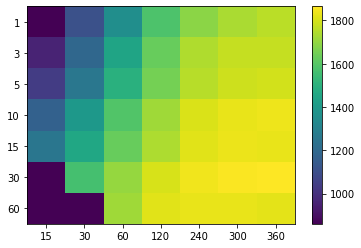

In [38]:
plt.imshow(counts,aspect='auto')
plt.yticks(range(len(t0_vals)),t0_vals)
plt.xticks(range(len(rt_tol_vals)),rt_tol_vals)
plt.colorbar()

In [58]:
log_counts_dict = {}

In [62]:
counts = np.zeros((len(t0_vals),len(rt_tol_vals)))

for i,t0 in enumerate(t0_vals):
    if not t0 in log_counts_dict:
        log_counts_dict[t0] = {}
    for j,r in enumerate(rt_tol_vals):
        print(t0,r)
        if t0 > r:
            # impossible combination
            counts[i,j] = np.nan # fix for colour on boxplot
            log_counts_dict[t0][r] = np.nan
            continue
        if not r in log_counts_dict[t0]:
            fname = 'exlude_log_{}_{}.mzml'.format(t0,r)
            mz_file = MZMLFile(os.path.join(test_path,fname))
            scans2boxes,boxes2scans = map_boxes_to_scans(mz_file,boxes,half_isolation_window = 0)
            counts[i,j] = len(boxes2scans)
            log_counts_dict[t0][r] = counts[i,j]
        else:
            counts[i][j] = log_counts_dict[t0][r]
        print(counts)

1 15
Loaded 6447 scans
[[1214.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]]
1 60
Loaded 6446 scans
[[1214. 1751.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]]
1 120
Loaded 6456 scans
[[1214. 1751. 1854.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]]
1 240
Loaded 6438 scans
[[1214. 1751. 1854. 1835.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0

Loaded 4975 scans
[[1214. 1751. 1854. 1835. 1818. 1813.]
 [1220. 1759. 1858. 1835. 1820. 1811.]
 [1240. 1746. 1839. 1823. 1811. 1804.]
 [1256. 1760. 1857. 1851. 1844. 1835.]
 [  nan 1742. 1852. 1838. 1835. 1823.]
 [  nan 1720. 1834. 1799. 1795.    0.]]
60 3600
Loaded 4979 scans
[[1214. 1751. 1854. 1835. 1818. 1813.]
 [1220. 1759. 1858. 1835. 1820. 1811.]
 [1240. 1746. 1839. 1823. 1811. 1804.]
 [1256. 1760. 1857. 1851. 1844. 1835.]
 [  nan 1742. 1852. 1838. 1835. 1823.]
 [  nan 1720. 1834. 1799. 1795. 1789.]]


5176


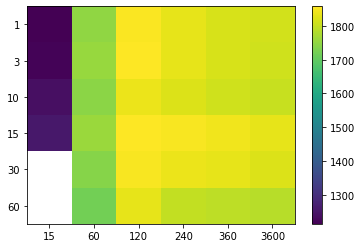

In [63]:
plt.imshow(counts,aspect='auto')
plt.yticks(range(len(t0_vals)),t0_vals)
plt.xticks(range(len(rt_tol_vals)),rt_tol_vals)
plt.colorbar()
print(len(boxes))

In [ ]:
# optimal pars: t0 = 15, rt_tol = 120.0

In [40]:
# smart_scans2boxes,smart_boxes2scans = map_boxes_to_scans(smart_mz_file,boxes,half_isolation_window = 0)
# roi_scans2boxes,roi_boxes2scans = map_boxes_to_scans(roi_mz_file,boxes,half_isolation_window = 0)
topn_mz_file = MZMLFile(os.path.join(test_path,'topN.mzml'))
topn_scans2boxes,topn_boxes2scans = map_boxes_to_scans(topn_mz_file,boxes,half_isolation_window = 0)
# note 0 in previous call is to only find the scans that have a precursor *in* the box, not those that overlap
print("topN: ",len(topn_boxes2scans))


Loaded 6300 scans
topN:  1256


In [ ]:
print("Boxes: ",len(boxes))
print("ROI: ",len(roi_boxes2scans))
print("topN: ",len(topn_boxes2scans))
print("SMART: ",len(smart_boxes2scans))

In [ ]:
# are they picking the same ones
roi_box_set = set(roi_boxes2scans.keys())
topn_box_set = set(topn_boxes2scans.keys())
smart_box_set = set(smart_boxes2scans.keys())
print(len(topn_box_set.intersection(smart_box_set)))

## QCA experiments

In [ ]:
base_dir = os.path.abspath('/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Trained Models')
base_dir_qcb = os.path.abspath('/home/simon/git/vimms/experimental/simon_res/QCB')
base_dir_qca = os.path.abspath('/home/simon/git/vimms/experimental/simon_res/QCA')

ps_frag_QCB = load_obj(Path(base_dir_qcb, 'peak_sampler_mz_rt_int_beerqcb_fragmentation.p'))

In [ ]:
QCB_MZML2CHEMS_DICT = {'min_ms1_intensity': 0,
                  'mz_tol': 5,
                  'mz_units':'ppm',
                  'min_length':1,
                  'min_intensity':0,
                  'start_rt':0,
                  'stop_rt':1560}

In [ ]:
TopN_QCA_dataset = load_obj('/home/simon/git/vimms/experimental/simon_res/QCA/TopN_QCA_dataset.mzml')

In [ ]:
min_rt = 0
max_rt = 26*60 # entire run
min_ms1_intensity = 5000
mz_tol = 10
rt_tol = 15
N = 10


# these are derived from real data (see bottom of notebook)
roi_time_dict = {1: 0.71,2:0.20}
topn_time_dict = {1: 0.60,2:0.20}


ionisation_mode = POSITIVE
isolation_width = 1

test_path = '/home/simon/git/vimms/experimental/simon_res/'
min_roi_intensity = 500
min_roi_length = 3 # still in scans, as to work in seconds, need to pass parameter. But doesn't matter when parameter below is equal to 1!
min_roi_length_for_fragmentation = 1



In [ ]:
output_folder = os.path.join(test_path,'output_files','QCA')

## TopN

In [ ]:
controller = TopNController(ionisation_mode, N, isolation_width, mz_tol, rt_tol, min_ms1_intensity)

mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCA_dataset,
                                        ps_frag_QCB, add_noise=True,
                                       scan_duration_dict = topn_time_dict)

env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

# test_path = '/Users/simon/git/vimms/experimental/simon_res/'
env.write_mzML(output_folder, 'topN.mzml')

In [ ]:
# SMART ROI
reset_length_seconds = 1e6 # set so reset never happens

iif_values = [2,3,5,10,1e3,1e6]
# dp_values = [1,5,20,50]
# dp_values = [0.1,0.5]
# dp_values = [0]
dp_values = [0,0.1,0.5,1,5]
# iif_values = [1e6]

In [ ]:
for iif in iif_values:
    for dp in dp_values:
        print(iif,dp)
        intensity_increase_factor = iif # fragment ROI again if intensity increases 10 fold
        drop_perc = dp/100


        # ROI can also be fragmented again if intensity falls to <1% of the max *since* last fragmentation
        from vimms.Controller import TopN_SmartRoiController
        controller = TopN_SmartRoiController(ionisation_mode, isolation_width, mz_tol, min_ms1_intensity,
                                             min_roi_intensity, min_roi_length, N = N, rt_tol = rt_tol, 
                                             min_roi_length_for_fragmentation = min_roi_length_for_fragmentation,
                                             reset_length_seconds = reset_length_seconds,
                                             intensity_increase_factor = intensity_increase_factor,
                                             drop_perc = drop_perc)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCA_dataset,
                                                ps_frag_QCB,
                                                add_noise=True,
                                               scan_duration_dict=roi_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        out_name = 'SMART3_{}_{}.mzml'.format(iif,dp)
        env.write_mzML(output_folder, out_name)

In [ ]:
# test with picked peaks
from ms2_matching import MZMLFile,load_picked_boxes,map_boxes_to_scans
peak_csv_file = os.path.join(test_path,'QCA','qca_pp_wide.csv')
boxes = load_picked_boxes(peak_csv_file)

In [ ]:
topn_mz_file = MZMLFile(os.path.join(output_folder,'topN.mzml'))
topn_scans2boxes,topn_boxes2scans = map_boxes_to_scans(topn_mz_file,boxes,half_isolation_window = 0)
# note 0 in previous call is to only find the scans that have a precursor *in* the box, not those that overlap
print("topN: ",len(topn_boxes2scans))


In [ ]:
counts = np.zeros((len(iif_values),len(dp_values)))
for i,iif in enumerate(iif_values):
    for j,dp in enumerate(dp_values):
        print(iif,dp)
        fname = 'SMART3_{}_{}.mzml'.format(iif,dp)
        mz_file = MZMLFile(os.path.join(test_path,'output_files','QCA',fname))
        scans2boxes,boxes2scans = map_boxes_to_scans(mz_file,boxes,half_isolation_window = 0)
        counts[i,j] = len(boxes2scans)
        print(counts)

In [ ]:
plt.imshow(counts,aspect='auto')
plt.yticks(range(len(iif_values)),iif_values)
plt.xticks(range(len(dp_values)),dp_values)
plt.colorbar()

## Extract some timings from real data

- Cells below extract the scan durations from the real data and compute the mean -- these are then used above in the simulations

In [ ]:
mzml_QCB_TopN
real_QCB_TopN = MZMLFile(mzml_QCB_TopN)


In [ ]:
time_dict = {(1,1):[],(1,2):[],(2,1):[],(2,2):[]}
for i,s in enumerate(real_QCB_TopN.scans[:-1]):
    current = s.ms_level
    next_ = real_QCB_TopN.scans[i+1].ms_level
    tup = (current,next_)
    time_dict[tup].append(60*real_QCB_TopN.scans[i+1].rt_in_minutes - 60*s.rt_in_minutes)
    

In [ ]:
for k,v in time_dict.items():
    if len(v) > 0:
        print(k,sum(v)/len(v))

In [ ]:
mzml_QCB_TopN_Roi
real_QCB_TopN_Roi = MZMLFile(mzml_QCB_TopN_Roi)



In [ ]:
time_dict = {(1,1):[],(1,2):[],(2,1):[],(2,2):[]}
for i,s in enumerate(real_QCB_TopN_Roi.scans[:-1]):
    current = s.ms_level
    next_ = real_QCB_TopN_Roi.scans[i+1].ms_level
    tup = (current,next_)
    time_dict[tup].append(60*real_QCB_TopN_Roi.scans[i+1].rt_in_minutes - 60*s.rt_in_minutes)
    if tup == (1,1):
        print(i)

In [ ]:
for k,v in time_dict.items():
    if len(v) > 0:
        print(k,sum(v)/len(v))

In [ ]:
print(time_dict[(1,1)])

In [ ]:
print(real_QCB_TopN_Roi.scans[6534].rt_in_minutes)
print(real_QCB_TopN_Roi.scans[6535].rt_in_minutes)

In [ ]:
roi_time_dict = {1: 0.71,2:0.20}
topn_time_dict = {1: 0.60,2:0.20}

## Simon peak picking

In [ ]:
xml_file = '/Users/simon/git/vimms/batch_files/QCB_mzmine_batch_ms2.xml'
output_dir = '/Users/simon/git/vimms/experimental/simon_res/'
pick_peaks([smart_file],xml_template=xml_file, output_dir=output_dir)

In [ ]:
pick_peaks([topn_file],xml_template=xml_file, output_dir=output_dir)
pick_peaks([roi_file],xml_template=xml_file, output_dir=output_dir)

In [ ]:
from alignment import JoinAligner

In [ ]:
tt = JoinAligner()
tt.add_file('/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/TopNvsTopNroi/QCB/QCB_22May19_1_pp.csv')
print(len(tt.peaksets))
tt.add_file('/Users/simon/git/vimms/experimental/simon_res/topN_pp.csv')
print(len(tt.peaksets))

In [ ]:
tt_mat = tt.to_matrix()
plt.imshow(tt_mat,aspect='auto')
s = (tt_mat > 0).sum(axis=1)
count = (s==2).sum()
print(count)

In [ ]:
ss = JoinAligner()
ss.add_file('/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/TopNvsTopNroi/QCB/QCB_22May19_1_pp.csv')
ss.add_file('/Users/simon/git/vimms/experimental/simon_res/SMART_pp.csv')
ss_mat = ss.to_matrix()
plt.imshow(ss_mat,aspect='auto')
s = (ss_mat > 0).sum(axis=1)
count = (s==2).sum()
print(count)

In [ ]:
print(topn_file)